In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle

In [2]:
import pyathena.yt_analysis.plot_projection as pproj
reload(pproj)

C:\anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'pyathena.yt_analysis.plot_projection' from 'pyathena\yt_analysis\plot_projection.pyc'>

In [3]:
from pyathena.yt_analysis.plot_projection import *

In [5]:
import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0,old='no'):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
   
    aux=ya.set_aux(os.path.basename(surfnames))
    scalfnames=glob.glob(surfnames.replace('surf.p','scal?.p'))
    scalfnames.sort()
    starfnames=glob.glob(surfnames.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfnames.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
    nstar=len(starfnames)
    nscal=len(scalfnames)
       
    if nstar > 0:
        starfnames=starfnames[0]
        sp=read_starvtk(starfnames)
        
    frb=pickle.load(open(surfnames,'rb'))
    
    if nscal > 0:
        icm=pickle.load(open(scalfnames[iscal],'rb'))
        if icm[axis]['data'].max() > (icm_max*1.1):
            print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

    if 'time' in frb:
        tMyr=frb['time']
    else:
        time,sp=read_starvtk(starfname,time_out=True)
        tMyr=time*Myr
 
    
    extent=np.array(frb[axis]['bounds'])/1.e3
    x0=extent[0]
    y0=extent[2]
    Lx=extent[1]-extent[0]
    Lz=extent[3]-extent[2]
  
    if axis == 'z': ix=6
    else: ix=3
    iz=ix*Lz/Lx

    cism=plt.cm.bone_r #bone_r
    cicm=plt.cm.Reds #plt.cm.Reds
    cicm._init()
    x=np.arange(cicm.N)
    alphas=0.4*(np.tanh((x-100)/50.)+1)
    #alphas = np.linspace(0.5, 0.5, cicm.N)
    cicm._lut[:-3,-1] = alphas
    cicm._lut[-3,-1] = alphas.min()
    cicm._lut[-2,-1] = alphas.max()
  
    clim=aux['surface_density']['clim']
    cmin=clim[0]*0.027676
    cmax=clim[1]*0.027676
    #cmin=clim[0]
    #cmax=clim[1]
    if axis!='z': clim=(cmin*0.01,cmax)
    clim_icm=(0.0,0.5)
    norm_icm=Normalize()

    fig=plt.figure(0,figsize=(2*(ix+0.5),2*iz))
    #width_list=[1]*nsurf+[0.1]
    gs = gridspec.GridSpec(3,2,width_ratios=[1,0.1],wspace=0.0)
        
    if axis=='z':
        frbb = frb[axis]['data']#*0.027676
    else:
        frbb = frb[axis]['data']*0.027676*8
    ax1=plt.subplot(gs[:,0])
    im1=ax1.imshow(frbb,norm=LogNorm(),origin='lower',interpolation='bicubic')
    im1.set_extent(extent)
    im1.set_cmap(cism)
    im1.set_clim(clim)

    if nscal > 0:
        icm[axis]['data'] /= icm_max
        im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower',interpolation='bicubic')
        im11.set_extent(extent)
        im11.set_cmap(cicm) #iccm
        im11.set_clim(clim_icm)

    if nstar > 0: 
        scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor,old=old)

    if axis=='x' or axis=='z':
        cax=plt.subplot(gs[0,1])
        cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
        if axis=='x':
            cbar.set_label(r'<n$_H$> [cm$^{-3}$]',fontsize=45)
        elif axis=='z':
            cbar.set_label(r'$\Sigma_{\odot}$ [M$_{\odot}$ pc$^{-2}$]',fontsize=45)
        if nscal > 0:
            cax=plt.subplot(gs[1,1])
            cbar = fig.colorbar(im11,cax=cax,orientation='vertical')
            cbar.set_label(r'$C_{\rm ICM}$',fontsize=45)
        
        cax=plt.subplot(gs[2,1])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40], cmap='cool_r', norm=Normalize(vmin=0,vmax=40), orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$',fontsize=45)
    
    if nstar > 0:
        if axis=='x':
            cax=plt.subplot(gs[2,1])
            cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
                cmap='cool_r', norm=Normalize(vmin=0,vmax=40), 
                orientation='vertical')
            cbar.set_label(r'${\rm age [Myr]}$',fontsize=45)
            s1=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e3)/norm_factor,color='k',alpha=.8,label=r'$10^3 M_\odot$')
            s2=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e4)/norm_factor,color='k',alpha=.8,label=r'$10^4 M_\odot$')
            s3=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e5)/norm_factor,color='k',alpha=.8,label=r'$10^5 M_\odot$')
            starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
            if axis=='z':

                legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='upper left',ncol=3,bbox_to_anchor=(0.0, 1.15),
                            fontsize='medium',frameon=True)
            else:
                legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='lower right',fontsize=20,frameon=True)
    
    plt.setp(ax1,'xlim',(x0,x0+Lx))
    plt.setp(ax1,'ylim',(y0,y0+Lz))
    
    if axis=='z':
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
    
    if axis=='y':
        #plt.setp(axes,'xlabel','x [kpc]')
        plt.text(-0.25,3.2,'t = %s Myr' % int(tMyr),fontsize=30)
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        #plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_xlabel('y [kpc]')
        #ax1.set_ylabel('z [kpc]')
        ax1.set_yticklabels([],[])
    
    if pngfname is not None:
        plt.savefig(pngfname,bbox_inches='tight',num=0,dpi=200)
        plt.show()
        plt.close()
    else:
        plt.show()
        return fig

In [5]:
aux=ya.set_aux()

In [6]:
aux['surface_density']

{'clim': (0.1, 100),
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x71b89e8>,
 'label': '$\\Sigma\\;[{\\rm M}_{\\odot} {\\rm pc}^{-2}]$',
 'log': True}

250


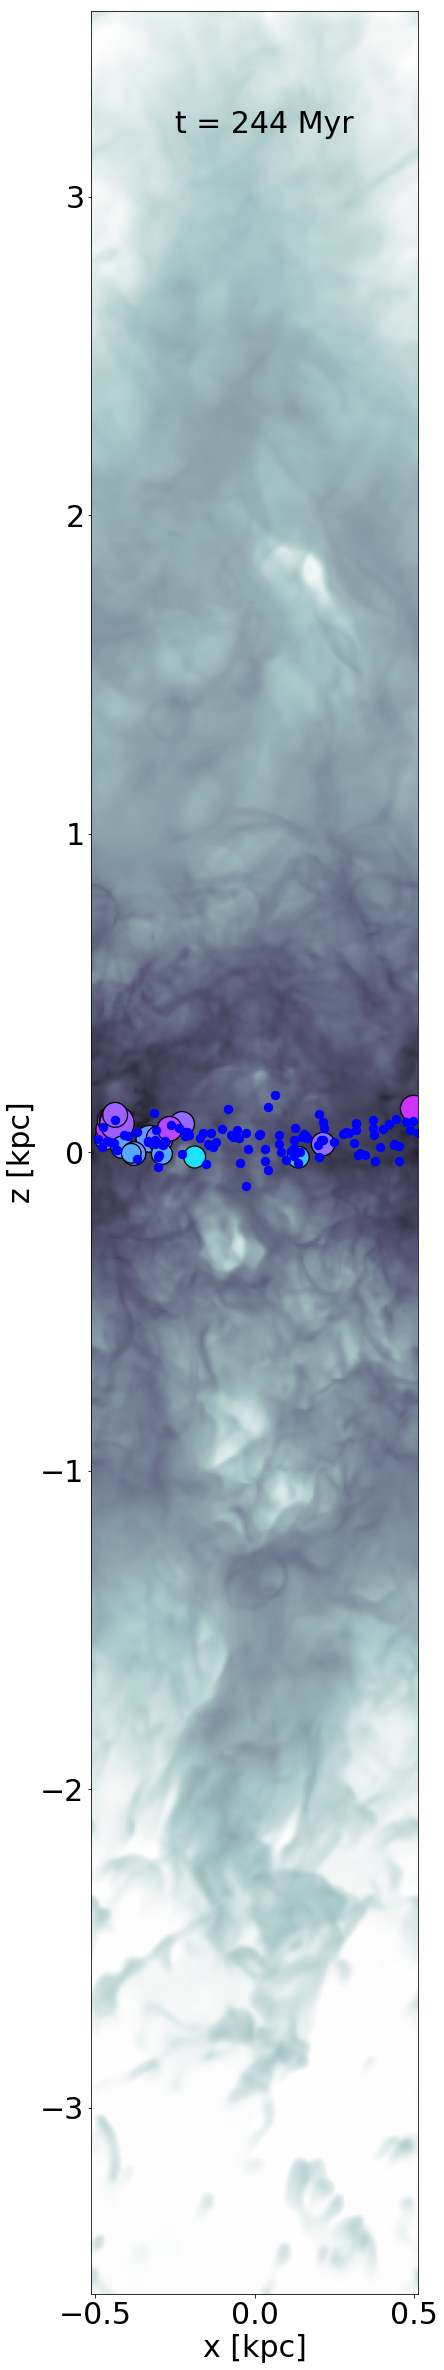

251


KeyboardInterrupt: 

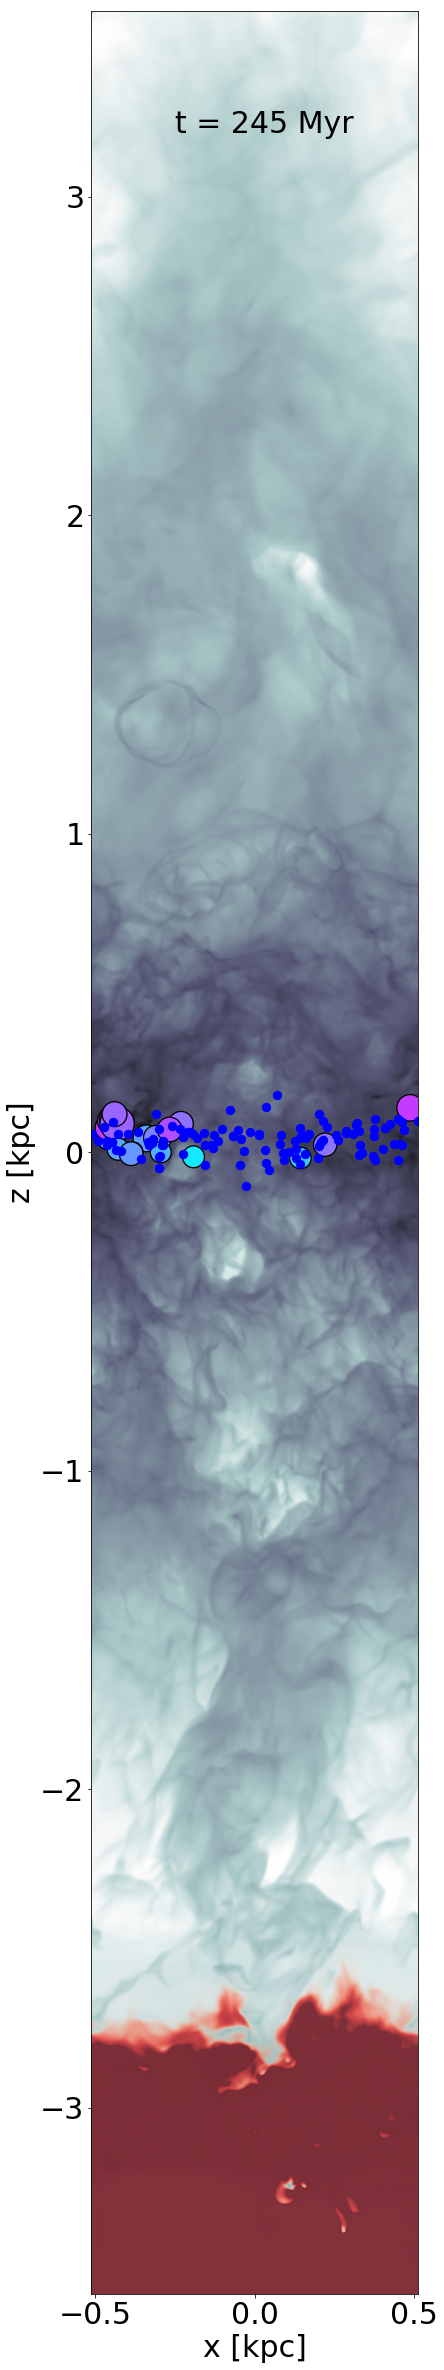

In [6]:
base='G:/yeongu/'
problem_id='RPS_4pc_ICM2_newacc'

#surfnames=[]
#for itime in range(250,500,15):
#    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))
axis='y'
for itime in range(250,473):
    surfnames= '{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    #print surfnames
    print itime
    fig=plot_projection_all(surfnames,axis=axis,runaway=False,iscal=3,norm_factor=0.25,old='yes',pngfname='D:/yeongu/plots/proj/new/old_new_surf_%s_%sproj_%s.png' % (problem_id,axis,itime))

In [8]:
#problem_id='RPS_8pc_ICM2_newacc'
axis='x'
for itime in range(250,473):
    surfnames= '{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    print itime
    fig=plot_projection_all(surfnames,axis=axis,runaway=False,iscal=3,norm_factor=0.25,pngfname='D:/yeongu/plots/proj/new/new_surf_%s_%sproj_%s.png' % (problem_id,axis,itime))

250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472


In [64]:
base='G:/yeongu/'
problem_id='RPS_8pc_noICM_newacc' #'R8_8pc_metal' #

#surfnames=[]
#for itime in range(250,500,15):
#    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))
axis='y'
for itime in range(250,499):
    surfnames= '{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    print itime
    fig=plot_projection_all(surfnames,axis=axis,runaway=False,iscal=3,norm_factor=0.25,pngfname='D:/yeongu/plots/proj/new/new_surf_%s_%sproj_%s.png' % (problem_id,axis,itime))

250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498


In [13]:
axis='x'
for itime in range(250,474):
    surfnames= '{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    print itime
    fig=plot_projection_all(surfnames,axis=axis,runaway=False,iscal=3,norm_factor=0.25,pngfname='D:/yeongu/plots/proj/new/new_surf_%s_%sproj_%s.png' % (problem_id,axis,itime))

250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473


In [10]:
import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
   
    aux=ya.set_aux(os.path.basename(surfnames))
    scalfnames=glob.glob(surfnames.replace('surf.p','scal?.p'))
    scalfnames.sort()
    starfnames=glob.glob(surfnames.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfnames.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
    nstar=len(starfnames)
    nscal=len(scalfnames)
       
    if nstar > 0:
        starfnames=starfnames[0]
        sp=read_starvtk(starfnames)
        
    frb=pickle.load(open(surfnames,'rb'))
    if nscal > 0:
        icm=pickle.load(open(scalfnames[iscal],'rb'))
        if icm[axis]['data'].max() > (icm_max*1.1):
            print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

    if 'time' in frb:
        tMyr=frb['time']
    else:
        time,sp=read_starvtk(starfname,time_out=True)
        tMyr=time*Myr
 
    
    extent=np.array(frb[axis]['bounds'])/1.e3
    x0=extent[0]
    y0=extent[2]
    Lx=extent[1]-extent[0]
    Lz=extent[3]-extent[2]
  
    if axis == 'z': ix=6
    else: ix=3
    iz=ix*Lz/Lx

    cism=plt.cm.bone_r #bone_r
    cicm=plt.cm.Reds #plt.cm.Reds
    cicm._init()
    x=np.arange(cicm.N)
    alphas=0.4*(np.tanh((x-100)/50.)+1)
    #alphas = np.linspace(0.5, 0.5, cicm.N)
    cicm._lut[:-3,-1] = alphas
    cicm._lut[-3,-1] = alphas.min()
    cicm._lut[-2,-1] = alphas.max()
  
    clim=aux['surface_density']['clim']
    cmin=clim[0]*0.027676
    cmax=clim[1]*0.027676
    #cmin=clim[0]/64. # for z projection
    #cmax=clim[1]/64.
    #clim = (cmin,cmax)
    if axis!='z': clim=(cmin*0.01,cmax)
    clim_icm=(0.0,0.5)
    norm_icm=Normalize()

    fig=plt.figure(0,figsize=(ix+0.5,iz))
    #width_list=[1]*nsurf+[0.1]
    gs = gridspec.GridSpec(3,2,width_ratios=[1,0.1],wspace=0.0)
        

    #frbb = frb[axis]['data']/64. # for z projection
    frbb = frb[axis]['data']
    
    ax1=plt.subplot(gs[:,0])
    im1=ax1.imshow(frbb,norm=LogNorm(),origin='lower')
    im1.set_extent(extent)
    im1.set_cmap(cism)
    im1.set_clim(clim)
    '''
    if nscal > 0:
        icm[axis]['data'] /= icm_max
        im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower')
        im11.set_extent(extent)
        im11.set_cmap(cicm) #iccm
        im11.set_clim(clim_icm)
    '''
    if nstar > 0: 
        scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor)

    
    cax=plt.subplot(gs[0,1])
    cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
    cbar.set_label(r'$\Sigma$ [M$_\odot$pc$^{-2}$]',fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    '''
    cax=plt.subplot(gs[1,1])
    cbar = fig.colorbar(im11,cax=cax,orientation='vertical',ticks=[0,0.25,0.5])
    cbar.ax.set_yticklabels(['0', '0.25', '0.5'])
    cbar.set_label(r'$C_{\rm ICM}$',fontsize=20)
    #cbar1.set_ticks(labelsize=10)
    cbar.ax.tick_params(labelsize=20)
    '''
    
    if nstar > 0:
        cax=plt.subplot(gs[2,1])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
                cmap='cool_r', norm=Normalize(vmin=0,vmax=40), 
                orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$',fontsize=20)
        cbar.ax.tick_params(labelsize=20)
        s1=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e3)/norm_factor,color='k',alpha=.8,label=r'$10^3 M_\odot$')
        s2=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e4)/norm_factor,color='k',alpha=.8,label=r'$10^4 M_\odot$')
        s3=ax1.scatter(Lx*2,Lz*2,s=np.sqrt(1.e5)/norm_factor,color='k',alpha=.8,label=r'$10^5 M_\odot$')
        starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
        if axis=='z':
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='upper left',ncol=1,bbox_to_anchor=(0.6, 0.35),
                            fontsize=15,frameon=True,framealpha=0.5)
        else:
            legend=ax1.legend((s1,s2,s3),starlabels,
                            loc='lower right',fontsize=20,frameon=True)
    
    plt.setp(ax1,'xlim',(x0,x0+Lx))
    plt.setp(ax1,'ylim',(y0,y0+Lz))
    
    if axis=='z':
        ax1.set_xlabel('x [kpc]',fontsize=15)
        ax1.set_ylabel('y [kpc]',fontsize=15)
        ax1.set_xticklabels([0,-0.5,0,0.5],fontsize=15)
        ax1.set_yticklabels([0,-0.5,-0.25,0,0.25,0.5],fontsize=15)
        plt.text(-2.2,3.2,'t = %s Myr' % int(tMyr),fontsize=10,color='w')
        #ax1.set_yticks(fontsize=25)
    
    if axis=='y':
        #plt.setp(axes,'xlabel','x [kpc]')
        plt.text(-0.36,3.2,'t = %s Myr' % int(tMyr),fontsize=20)
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        #plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_xlabel('y [kpc]')
        #ax1.set_ylabel('z [kpc]')
        ax1.set_yticklabels([],[])
    
    if pngfname is not None:
        plt.savefig(pngfname,bbox_inches='tight',num=0,dpi=200)
        #plt.show()
        plt.close()
    else:
        plt.show()
        return fig

F:/yeongu/R8_8pc_metal/surf/R8_8pc_metal.0250.surf.p
F:/yeongu/R8_8pc_metal/surf/R8_8pc_metal.0251.surf.p
F:/yeongu/R8_8pc_metal/surf/R8_8pc_metal.0252.surf.p
F:/yeongu/R8_8pc_metal/surf/R8_8pc_metal.0253.surf.p


KeyboardInterrupt: 

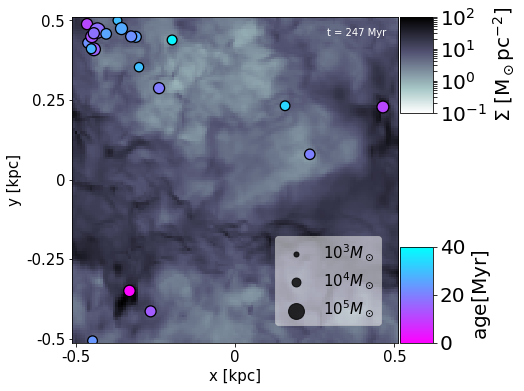

In [11]:
base='F:/yeongu/'
problem_id='R8_8pc_metal' #'RPS_8pc_ICM0'

axis='z'
for itime in range(250,500):
    surfnames= '{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    print surfnames
    fig=plot_projection_all(surfnames,axis=axis,runaway=False,iscal=4,norm_factor=1.25,pngfname='D:/yeongu/plots/proj/surf_%s_%sproj_%s.png' % (problem_id,axis,itime))